# First Practical Work

## Data Science and Engineering

### DESIGN OF AN IMAGE FILTER FUNCTION, PARALLELIZABLE AND SCALABLE

**Full name:** ANDRES ORTIZ 
    
**NIA** : **1004261219**

This code was developed with **RAUL MALLO ALONSO; NIA: 100429745**

In this section, we simply import the necessary dependencies to execute the filter

In [21]:
import numpy as np
import multiprocessing as mp
from multiprocessing.sharedctypes import Array
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile
import ctypes
import functions as my 

## Declaration of class attributes

Here we declare and assign the attributes that will be used in the subsequent methods.

In [22]:
F_IMAGE1="lena.png" 

In [23]:
image1= np.array(Image.open(F_IMAGE1))
image2= np.array(Image.open(F_IMAGE1))

* The first filter is impulse response filter (the image output must be equals to the original one).
* The second filter is an edge filter, first order in x axis,  
* The third filter is an edge filter, first order in y axis,
* the fourth filter is an edge filter, second order, bi-directional
* the fifth filter is a blur gausian filter.

In [24]:
filter1=np.array([
    [0,0,0,0,0],
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
])
filter2=np.array([0.5, 0 , -0.5])
filter3=np.array([[0.5],[0],[0.5]])

filter4=np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
filter5=np.array([
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.01330373,0.11098164,0.22508352,0.11098164,0.01330373],
    [0.00655965,0.05472157,0.11098164,0.05472157,0.00655965],
    [0.00078633,0.00655965,0.01330373,0.00655965,0.00078633]
])
filter6=np.array([0.5, 0 ,0,0, -0.5])
filter7=np.array([[0.5],[0],[0],[0],[0.5]])


We then calculate the size of each data buffer and allocate memory to each shared space where our filtered image data will be stored

In [25]:
data_buffer1_size=image1.shape[0]*image1.shape[1]*image1.shape[2]
shared_space1= Array(ctypes.c_byte,data_buffer1_size)

data_buffer2_size=image2.shape[0]*image2.shape[1]*image2.shape[2]
shared_space2= Array(ctypes.c_byte,data_buffer2_size)

## Declaration of auxiliary functions
The following function converts an array into a numpy array so that we can assign the shared memory spaces

In [26]:
def tonumpyarray(mp_arr):
    """
    This function creates a numpy array of uint8
    :param mp_arr: the array to be transformed
    """
    # mp_array is a shared memory array with a lock
    return np.frombuffer(mp_arr.get_obj(), dtype=np.uint8)

In order to filter the images, we create two processes with a different filter each. 
The Process object represents an activity that is run in a separate process. The start() function starts the process's activity, while the join() functions waits until the process whose join() method is called terminates the execution of the target function. (In this case, image_filter() is the target function)

These processes will split the number of cores available in half so that half of the resources work on process 1 and half work on process 2. These processes will each execute the image_filter() function which will then assign a thread pool to the task of computing the filter values. 
Once both processes are complete, the function finishes its execution. 

In [27]:
def filters_execution(p_image, p_filter1, p_filter2, p_numprocessors, p_shared_space1,
                      p_shared_space2):
    """
    This functions executes the two processes that will use the thread pools to run the fulters

    :param p_image: the image to be filtered
    :param p_filter1: the first filter
    :param p_filter2: the seconds filter
    :param p_numprocessors: the number of processors to be used
    :param p_shared_space1: the first shared memory space
    :param p_shared_space2: the second shared memory space
    """
    # creates a lock to handle memory access
    lock = mp.Lock()

    # define and start the processes
    p1 = mp.Process(target=my.image_filter, args=(p_image, p_filter1, p_numprocessors,
                                                  p_shared_space1))
    p2 = mp.Process(target=my.image_filter, args=(p_image, p_filter2, p_numprocessors,
                                                  p_shared_space2))

    # start the processes
    p1.start()
    p2.start()

    # wait until the processes have ended
    p1.join()
    p2.join()

## Apply Filter

Here, we divide the number of cpus in two and ensure that the value is an integer. This is the amount of processors that will be destined to each process.

In [28]:
numprocessors= int(mp.cpu_count()/2)
print(numprocessors)

4


Now, we execute the main filter function.filters_execution(image1,filter3,filter2,numprocessors,shared_space1,shared_space2)

In [29]:
filters_execution(image1,filter3,filter2,numprocessors,shared_space1,shared_space2)

## Visualization

In this last step, we take the filtered images that are stored in the multiprocessing vectors (filtered_image1_VECTOR) and (filtered_image2_VECTOR), convert them to numpy array, and reshape them to match the shape of the original image.

In [30]:
filtered_image1=tonumpyarray(shared_space1).reshape(image1.shape)
filtered_image2=tonumpyarray(shared_space2).reshape(image2.shape)

Finally, we display the images with the selected filters applied.

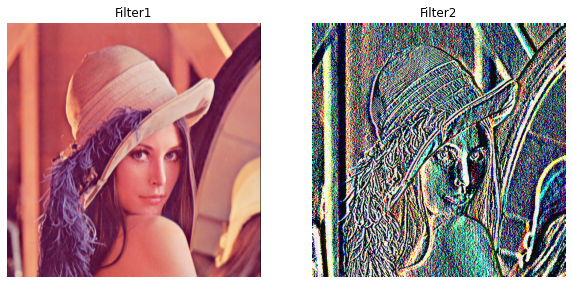

In [31]:
fig = plt.figure(figsize=(10, 7))

# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)

# showing image
plt.imshow(filtered_image1)
plt.axis('off')
plt.title("Filter1")

# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)

# showing image
plt.imshow(filtered_image2)
plt.axis('off')
plt.title("Filter2")

plt.show()

## Conclusion

The use of thread pools in this project allows us to take advantage of the concurrency offered by multicore architectures on modern computers. In software, when we execute an algorithm or a program using a single thread, we are leaving valuable resources unused. By using thread pools, we can maximize the amount of parallel tasks that are executed because a thread can be reused if a thread in a thread pool completes its execution and a new thread is created to replace a thread that is terminated. However, in this particalr case we are applying two filters on a single image simultaneously. In order to achieve this, we created two processes that divide the CPU's resources in two and store the results in a shared memory location. Now, the way the general algorithm works is great but it is limited since we are simply using Python's multiprocessing library. We would most likely see an increase in performance if we used the Ray framework. 
This framework is a faster and simpler framework for building and running distributed applications. The following article highlights the tradeoffs between using Ray vs using Python's multiprocessing. <https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1>.

Secondly, in this practical work we are processing images with the cores available on our machine. However, this is a huge bottleneck because CPUs on consumer machines don't usually come with a large amount of available cores. If we could process these images using a GPU, we would see a huge increase in performance since the number of threads avaiable on a GPU often  hundreds of times greater. GPUs use the SIMT (single instruction, multiple threads) programming model, so it is highly parallelizable. Additionally, GPUs have shared memory that simultaneously available to each core of one multiprocessor, is a lot faster than the bandwidth of of the L1 cache of a CPU
